In [1]:
import matplotlib
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA

sns.set_context('poster')
sns.set_style('white')

pd.options.mode.chained_assignment = None  # default='warn'

import hdbscan
from collections import Counter
from collections import defaultdict
from numpy import random

In [2]:
def normalize(x, r):
    M = np.divide(x, r)
    M_norm = np.full_like(M, 0)
    for i in range(np.shape(M)[0]):
        rev = 1 - M[i, :]
        if np.dot(M[i, :], M[i, :]) > np.dot(rev, rev):
            M_norm[i, :] = rev
        else:
            M_norm[i, :] = M[i, :]
    return M_norm

In [3]:
def draw_PCA(f_pca, black_points=None):
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=10, linewidth=0, alpha=0.2);
    if black_points is not None:
        plt.scatter(f_pca[black_points, 0], f_pca[black_points, 1], s=10, linewidth=0, c="black", alpha=1);
        plt.title("%s/%s points" % (np.sum(black_points), len(f_pca)))
    else:
        plt.title("%s points" % len(f_pca))

In [4]:
def filter_by_coverage(cur_r, bad_percent, bad_samples):
    def filter_row(row):
        num_of_samples = len(row)
        valid = np.sum(np.array(([(min_coverage < row) & (row < max_coverage)])))
        return num_of_samples - valid <= bad_samples

    min_coverage = np.percentile(cur_r, bad_percent, axis=0)
    max_coverage = np.percentile(cur_r, 100-bad_percent, axis=0)
    good_coverage = np.array([filter_row(row) for row in cur_r])
    return good_coverage

(Вспомогательная процедура, которая рисует легенду с обозначением цветов.)

In [5]:
def draw_legend(class_colours, classes, right=False):
    recs = []
    for i in range(0, len(classes)):
        recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
    if right:
        plt.legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(recs, classes)

SNP, встречающиеся в комбинации стрейнов

In [6]:
 def plot_shared_snps(f_pca, mask, names, draw_all=False):
    combs = []
    combs_nums = []
    combinations = []

    for m in mask:
        if not draw_all:
            if not (np.sum(m) > 1):
                combinations.append(-1)
                continue
        cur = ""
        for i in range(len(m)):
            if m[i] == 1:
                if cur != "":
                    cur += " + "
                cur += names[i] 
        if cur == "":
            cur = "none"                   
        if cur not in combs:
            combs.append(cur)
            combs_nums.append(0)
        combs_nums[combs.index(cur)] += 1
        combinations.append(combs.index(cur))

    df = pd.DataFrame({'pc1':f_pca[:, 0], 'pc2':f_pca[:, 1], 'combination':combinations})
    df_valid = df.loc[df['combination'] != -1]

    # reoder combinations by sizes of groups
    order = sorted(zip(combs_nums, combs, range(12)), reverse=True)
    new_comb_order = [0] * (2 ** len(mask[0]))
    new_comb_names = [] 
    for i in range(len(order)):
        old_order = order[i][2]
        new_comb_order[old_order] = i
        new_comb_names.append('{:5d}'.format(order[i][0]) + '  ' + order[i][1])
        #new_comb_names.append(order[i][1])
    for i in df_valid.index:
        df_valid.loc[i, "combination"] = new_comb_order[df_valid.loc[i, "combination"]]

    # Kelly’s 20 (except the first 2) Colours of Maximum Contrast
    colors = ['yellow', 'purple', 'orange', '#96cde6', 'red', '#c0bd7f', '#7f7e80', '#5fa641', '#d485b2', 
              '#4277b6', '#df8461', '#463397', '#e1a11a', '#91218c', '#e8e948', '#7e1510',
              '#92ae31', '#6f340d', '#d32b1e', '#2b3514']
    color_palette = sns.color_palette(colors)
    cluster_colors = [color_palette[x] for x in df_valid["combination"]]

    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.scatter(df_valid["pc1"], df_valid["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.6);
    #plt.title("[Sharon et al, 2013]")
    draw_legend(color_palette, new_comb_names, right=True)

In [144]:
def sizes_to_probs(s):
    s_log = np.log(s)
    return s_log / s_log.sum()


def subsample_from_cluters(Npoints, labels):
    groupby_labels = defaultdict(list)
    for i in range(len(labels)):
        groupby_labels[labels[i]].append(i)
    groupby_labels = dict(groupby_labels)

    cluster_size = np.array([len(groupby_labels[i]) for i in groupby_labels.keys()], dtype=int)
    print("exemplars sizes:")
    print(list(cluster_size), "\n")
    cluster_size = Npoints * sizes_to_probs(cluster_size)
    print("subsamplings sizes:")
    print([int(round(s)) for s in cluster_size], "\n")

    subsamples = {}
    for i in groupby_labels.keys():
        subsample_size = int(round(cluster_size[i]))
        subsample_index = random.choice(groupby_labels[i], size=subsample_size, replace=True).tolist()
        subsamples[i] = subsample_index

    ind = [val for sublist in list(subsamples.values()) for val in sublist]
    random.shuffle(ind)
    return ind


def clusterization(f, pca=True, num_of_comp=2):
    
    if pca:
        f_pca = PCA(n_components = num_of_comp).fit(f).transform(f)
        cur_f = f_pca
    else:
        cur_f = f
        f_pca = PCA(n_components = 2).fit(f).transform(f)
    
    #N = (nt) (len(f) * 0.005)
    #print(N)
    N = 100

    clusterer = hdbscan.HDBSCAN(min_cluster_size=N, min_samples=1).fit(cur_f)
    
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    if pca:
        plt.title("Clustering %s primary components" % num_of_comp)
    else:
        plt.title("Clustering initial frequencies")        
    
    color_palette = sns.color_palette("Set2", 20)
    cluster_colors = [color_palette[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, clusterer.probabilities_)]
    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=40, linewidth=0, c=cluster_member_colors, alpha=0.3);
    
    #exemplars_ind = indexes_of_rows(cur_f, np.concatenate(clusterer.exemplars_))
    #plt.scatter(f_pca[exemplars_ind, 0], f_pca[exemplars_ind, 1], s=7, linewidth=0, c="black", alpha=0.9);
    
    sizes_of_classes = Counter(clusterer.labels_)
    print(sizes_of_classes.get(-1, 0), "outliers\n")
    labels = [str(x) + ' - ' + str(sizes_of_classes[x]) for x in range(max(clusterer.labels_)+1)]
    draw_legend(color_palette, labels, right=True)  
        
    print("Medians in clusters:")
    for i in range(max(clusterer.labels_)+1):
        f_with_labels = f.copy()
        f_with_labels = np.hstack([f_with_labels, clusterer.labels_.reshape(len(f_with_labels),1)])
        col = f_with_labels[:, -1]
        idx = (col == i)
        print(i, np.round(np.median(f_with_labels[idx,:-1], axis=0), 2))

# Infant Gut, выровненный на Strain 1
(Преобразование не делаем, так как референс есть в данных)

##### Частоты стрейнов в Infant Gut:

strain1 0.73 0.74 0.04 0.13 0.17 0.04 0.32 0.75 0.30 0.20 0.0

strain3 0.24 0.20 0.95 0.80 0.80 0.93 0.52 0.19 0.64 0.65 1.0

strain4 0.03 0.06 0.02 0.07 0.03 0.02 0.16 0.06 0.06 0.15 0.0

In [130]:
r = np.genfromtxt("infant_gut_pure_STRAIN1/matrices/R_all", dtype=int, delimiter=' ')
x = np.genfromtxt("infant_gut_pure_STRAIN1/matrices/X_all", dtype=int, delimiter=' ')
names = ["strain 1", "strain 3", "strain 4"]
num_of_strains = len(names)

print("%s sites" % len(r))

f = normalize(x, r)

53584 sites


Читаем маску и удаляем первые 4 колонки:

In [131]:
mask = x[:, 0:(num_of_strains-1)]
mask[mask > 0] = 1
r = np.delete(r, [i for i in range(num_of_strains)], axis=1)
x = np.delete(x, [i for i in range(num_of_strains)], axis=1)

Удаляем снипы с покрытием, близким к 0 или 1:

In [132]:
Ncut = 6
print("Delete zero and almost zero profiles:")
good_ind = [i for i in range(np.shape(x)[0]) 
            if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
print(len(good_ind), "remained")

x = x[good_ind, :]
r = r[good_ind, :]
mask = mask[good_ind, :]

Delete zero and almost zero profiles:
13384 remained


Рисуем получившиеся фичи на главных компонентах и отмечаем те точки, у которых неплохое покрытие по R. 

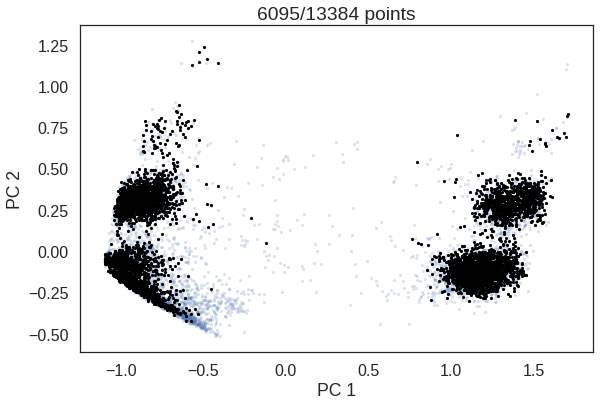

In [133]:
f = np.divide(x, r)
f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca, filter_by_coverage(r, 15, 2))

Оставляем только точки с хорошим покрытием.

In [134]:
good_coverage = filter_by_coverage(r, 15, 2)
mask_filtered = mask[good_coverage, :]

f_withoutT_filtered = np.divide(x, r)[good_coverage, :]
f_pca_withoutT_filtered = PCA(n_components=2).fit(f_withoutT_filtered).transform(f_withoutT_filtered)

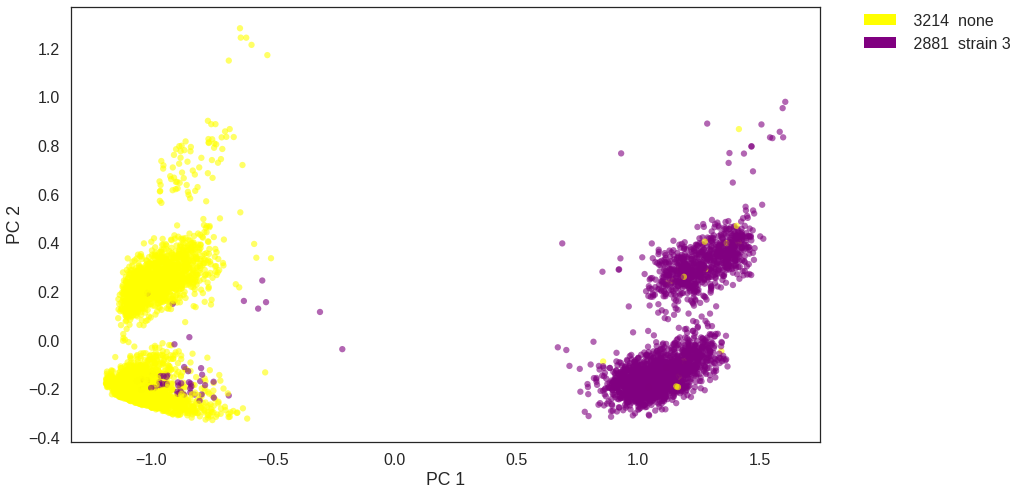

In [127]:
plot_shared_snps(f_pca_withoutT_filtered, mask_filtered, names, draw_all=True)

Кластеризация так и сяк.

0 outliers

Medians in clusters:
0 [ 0.05  0.08  0.    0.02  0.06  0.04  0.08  0.07  0.04  0.12  0.02]
1 [ 0.18  0.16  0.97  0.84  0.81  0.92  0.56  0.15  0.64  0.72  0.97]


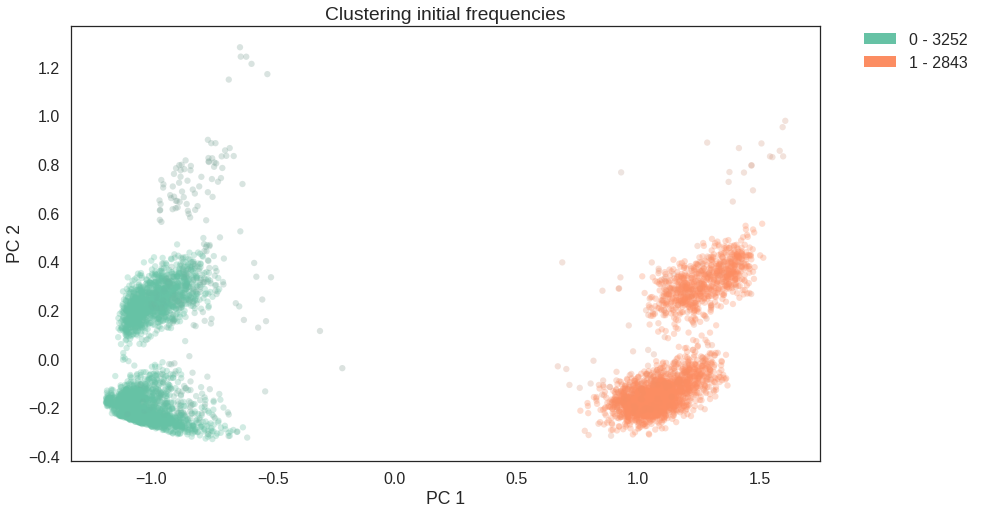

In [146]:
clusterization(f_withoutT_filtered, pca=False)

Смотрим, какой снип кому соответствует.

In [ ]:
   0.24   0.20  0.95  0.80  0.80  0.93  0.52  0.19  0.64  0.65 1.0

270 outliers

Medians in clusters:
0 [ 0.15  0.13  0.96  0.82  0.78  0.92  0.54  0.12  0.62  0.7   0.97]
1 [ 0.48  0.37  1.    0.88  0.92  0.95  0.64  0.37  0.7   0.8   0.98]
2 [ 0.3   0.24  0.    0.05  0.13  0.02  0.05  0.24  0.07  0.09  0.  ]
3 [ 0.01  0.01  0.    0.    0.01  0.04  0.1   0.01  0.01  0.19  0.04]


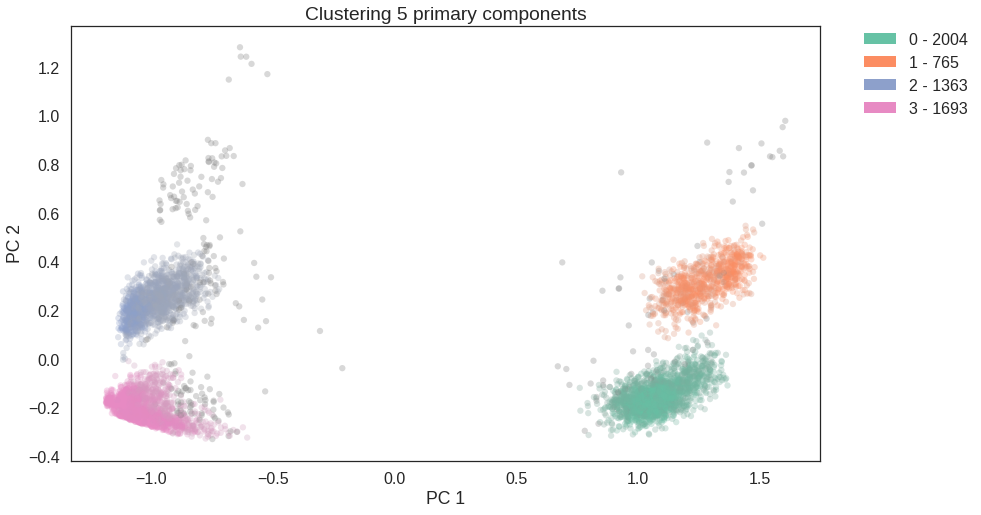

In [145]:
clusterization(f_withoutT_filtered, pca=True, num_of_comp=5)

# Infant Gut, выровненный на референс NCBI
(Здесь делаем преобразование.)

In [147]:
r = np.genfromtxt("infant_gut_pure_without_ref/matrices/R_all", dtype=int, delimiter=' ')
x = np.genfromtxt("infant_gut_pure_without_ref/matrices/X_all", dtype=int, delimiter=' ')
names = ["strain 1", "strain 3", "strain 4"]
num_of_strains = len(names)

print("%s sites" % len(r))

54466 sites


In [148]:
mask = x[:, 0:(num_of_strains-1)]
mask[mask > 0] = 1
r = np.delete(r, [i for i in range(num_of_strains)], axis=1)
x = np.delete(x, [i for i in range(num_of_strains)], axis=1)

In [149]:
Ncut = 6
print("Delete zero and almost zero profiles:")
good_ind = [i for i in range(np.shape(x)[0]) 
            if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
print(len(good_ind), "remained")

x = x[good_ind, :]
r = r[good_ind, :]
mask = mask[good_ind, :]

Delete zero and almost zero profiles:
13860 remained


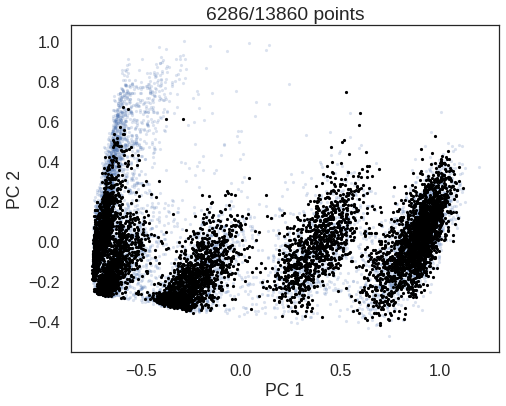

In [150]:
f = normalize(x, r)
f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca, filter_by_coverage(r, 15, 2))

good_coverage = filter_by_coverage(r, 15, 2)
mask_filtered = mask[good_coverage, :]

f_filtered = normalize(x, r)[good_coverage, :]
f_pca_filtered = PCA(n_components=2).fit(f_filtered).transform(f_filtered)

In [151]:
#plot_shared_snps(f_pca_filtered, mask_filtered, names, draw_all=True)

In [152]:
#clusterization(f_filtered, pca=True)

Если же преобразование не делать...

In [153]:
#clusterization(f_filtered, pca=False)

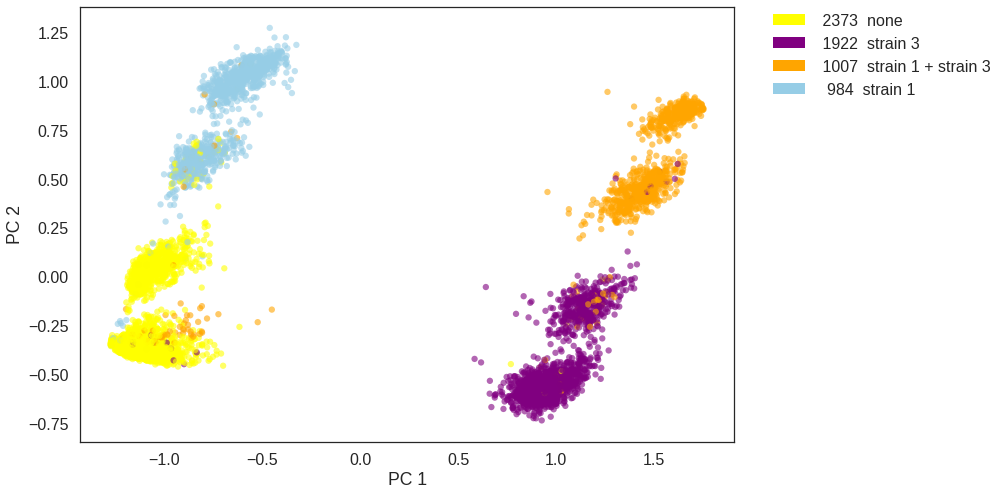

In [154]:
f_withoutT_filtered = np.divide(x, r)[good_coverage, :]
f_pca_withoutT_filtered = PCA(n_components=2).fit(f_withoutT_filtered).transform(f_withoutT_filtered)

plot_shared_snps(f_pca_withoutT_filtered, mask_filtered, names, draw_all=True)

55 outliers

Medians in clusters:
0 [ 0.82  0.82  0.03  0.14  0.19  0.05  0.4   0.84  0.33  0.23  0.02]
1 [ 0.49  0.58  0.    0.09  0.05  0.02  0.31  0.6   0.26  0.14  0.02]
2 [ 0.97  0.95  1.    0.98  0.97  0.96  0.95  0.96  0.93  0.93  1.  ]
3 [ 0.66  0.72  1.    0.92  0.84  0.94  0.88  0.74  0.89  0.86  0.98]
4 [ 0.29  0.23  0.    0.04  0.13  0.02  0.    0.24  0.05  0.06  0.  ]
5 [ 0.01  0.01  0.    0.    0.01  0.05  0.11  0.01  0.01  0.2   0.06]
6 [ 0.46  0.34  1.    0.85  0.91  0.93  0.57  0.35  0.66  0.74  0.97]
7 [ 0.14  0.12  0.96  0.81  0.77  0.91  0.53  0.11  0.61  0.68  0.96]


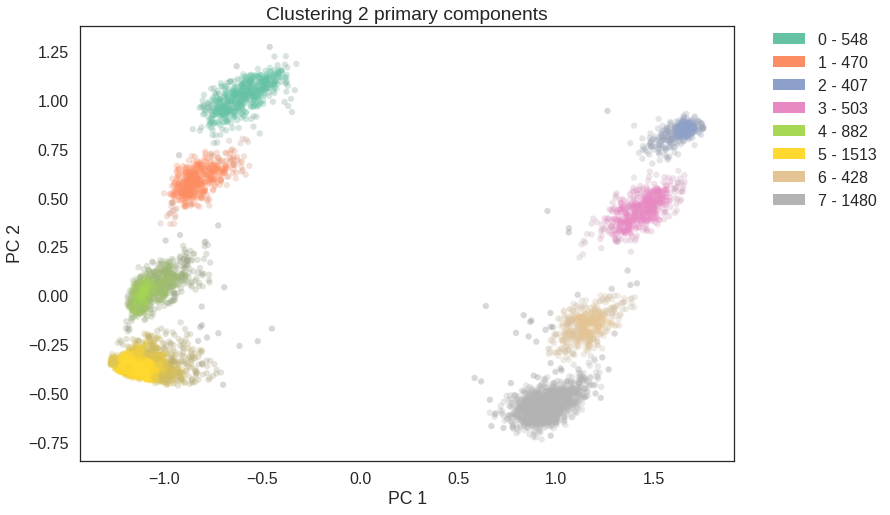

In [155]:
clusterization(f_withoutT_filtered, pca=True, num_of_comp=2)

### Отфильтруем жестче

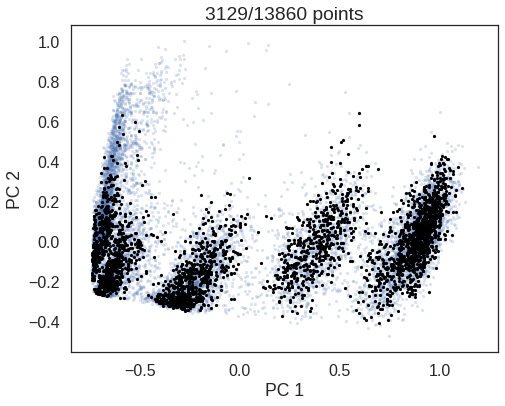

In [156]:
f = normalize(x, r)
f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca, filter_by_coverage(r, 25, 3))

good_coverage = filter_by_coverage(r, 25, 3)
mask_filtered = mask[good_coverage, :]

f_filtered = normalize(x, r)[good_coverage, :]
f_pca_filtered = PCA(n_components=2).fit(f_filtered).transform(f_filtered)

In [91]:
#plot_shared_snps(f_pca_filtered, mask_filtered, names, draw_all=True)

In [92]:
#clusterization(f_filtered, pca=False)

In [93]:
#clusterization(f_filtered, pca=True)

Если же преобразование не делать...

In [157]:
f_withoutT_filtered = np.divide(x, r)[good_coverage, :]
f_pca_withoutT_filtered = PCA(n_components=2).fit(f_withoutT_filtered).transform(f_withoutT_filtered)

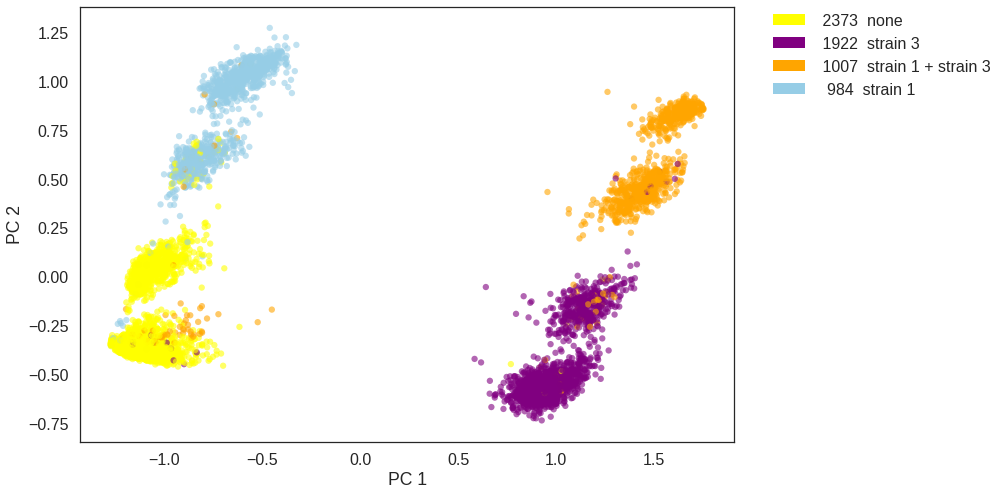

In [94]:
plot_shared_snps(f_pca_withoutT_filtered, mask_filtered, names, draw_all=True)

32 outliers

Medians in clusters:
0 [ 0.48  0.58  0.    0.09  0.06  0.02  0.32  0.6   0.26  0.15  0.02]
1 [ 0.82  0.81  0.04  0.14  0.19  0.05  0.39  0.84  0.33  0.23  0.02]
2 [ 0.97  0.95  1.    0.98  0.97  0.97  0.96  0.96  0.93  0.93  1.  ]
3 [ 0.65  0.72  1.    0.92  0.84  0.94  0.88  0.74  0.88  0.86  0.98]
4 [ 0.46  0.34  1.    0.86  0.9   0.93  0.56  0.35  0.66  0.75  0.98]
5 [ 0.14  0.12  0.96  0.81  0.77  0.9   0.53  0.12  0.61  0.69  0.96]
6 [ 0.3   0.23  0.    0.04  0.13  0.02  0.    0.24  0.05  0.06  0.  ]
7 [ 0.01  0.01  0.    0.01  0.01  0.04  0.1   0.01  0.01  0.16  0.04]


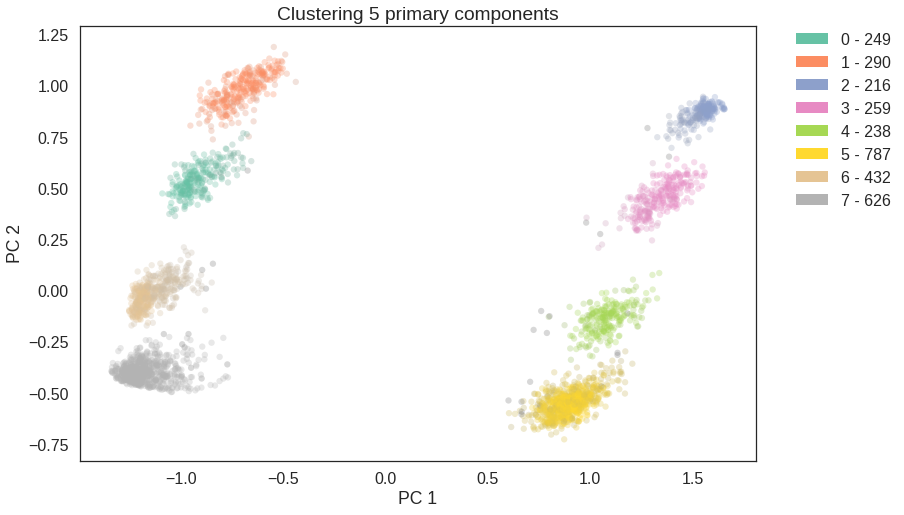

In [158]:
clusterization(f_withoutT_filtered, pca=True, num_of_comp=5)